In [1]:
!nvidia-smi --query-gpu=gpu_name --format=csv

name
Tesla T4


In [43]:
%load_ext autoreload
%autoreload 2

import sys
import os
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/coin-wear-estimator/notebook')
  !pip3 install -r ../requirements.txt --quiet
  !apt install -qq ocl-icd-* opencl-headers 

if ".." not in sys.path:
  sys.path.append("..")

import torch
if torch.cuda.is_available():
  from h2o4gpu.solvers import KMeans
else:
  from sklearn.cluster import KMeans
  
import pandas as pd
import numpy as np
import cv2
from cv2.xfeatures2d import SIFT_create as SIFTDetector
from matplotlib import pyplot as plt
from bunch import Bunch
from silx.opencl import sift as silx_sift

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# import torchvision
# from torchvision import datasets, models, transforms
import time
import copy
from collections import Counter
import typing

from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch

from silx.opencl import sift as silx_sift

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse

from src.bow.visual_utils import *
from src.bow.bow import  *
from src.utils import *
from src.grade_processing_utils import calculate_sheldon_and_categories
from src.dataset_utils import load_dataset, to_h5, join_datasets, get_h5_name
from src.master_coin_utils import convert_to_wear_marks_dataset
from src.bow.svc import optimize_model
from src.detector import BriefDetector, SiftGPUDetector

from src.detector import BACKGROUND_VALUE
import numpy as np
import cv2
import numpy as np
import pandas as pd
from src.utils import *
import pandas as pd
from src.image_utils import remove_illumination
from tqdm.notebook import tqdm
from bunch import Bunch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of src.grade_processing_utils failed: Traceback (most recent call last):
  File "/Users/telepchuk/PWr/Dan_III/Magister/coin-wear-estimator/coin-wear-venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/telepchuk/PWr/Dan_III/Magister/coin-wear-estimator/coin-wear-venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/telepchuk/.pyenv/versions/3.9.5/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/telepchuk/.pyenv/versions/3.9.5/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 851, in exec_module
  File "<frozen importlib._bootstrap_external>", line 988, in get_code
  File "<frozen importlib._bootstrap_ext

# Load Dataset

In [44]:
%time

separate_sides = False
uncertain = True
ds_shape = (700,700)

dataset = join_datasets([
  load_dataset(MARCINIAK_DATASET_PATH, separate_sides=separate_sides, ds_shape=ds_shape, uncertain=uncertain),
  load_dataset(NIEMCZYK_DATASET_PATH, separate_sides=separate_sides,ds_shape=ds_shape, uncertain=uncertain),
])
  
# to_h5(dataset, "two_sides_750.h5")
to_h5(dataset, get_h5_name(separate_sides=separate_sides, uncertain=uncertain))
# dataset = load_dataset(h5_path=get_h5_name(separate_sides=separate_sides, uncertain=uncertain))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

## Two sides dataset

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=False, uncertain=False))

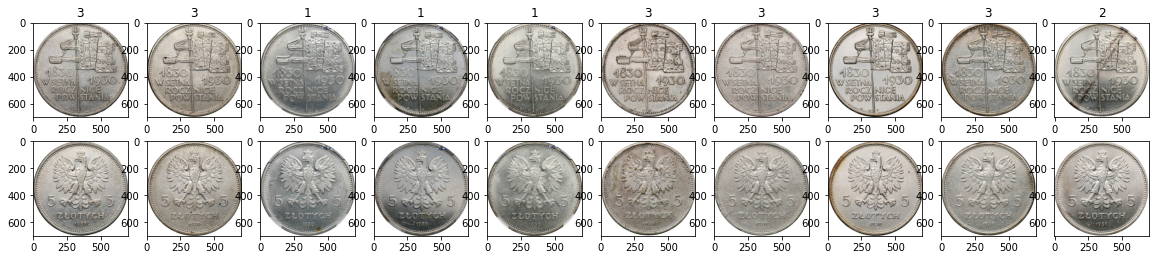

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(20,4))
ax = ax.T.flatten()
for i in range(10):
    ax[i*2].imshow(cv2.cvtColor(dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i*2+1].imshow(cv2.cvtColor(dataset.X[i][1], cv2.COLOR_BGR2RGB))
    ax[i*2].set_title(dataset.y[i])
plt.show()

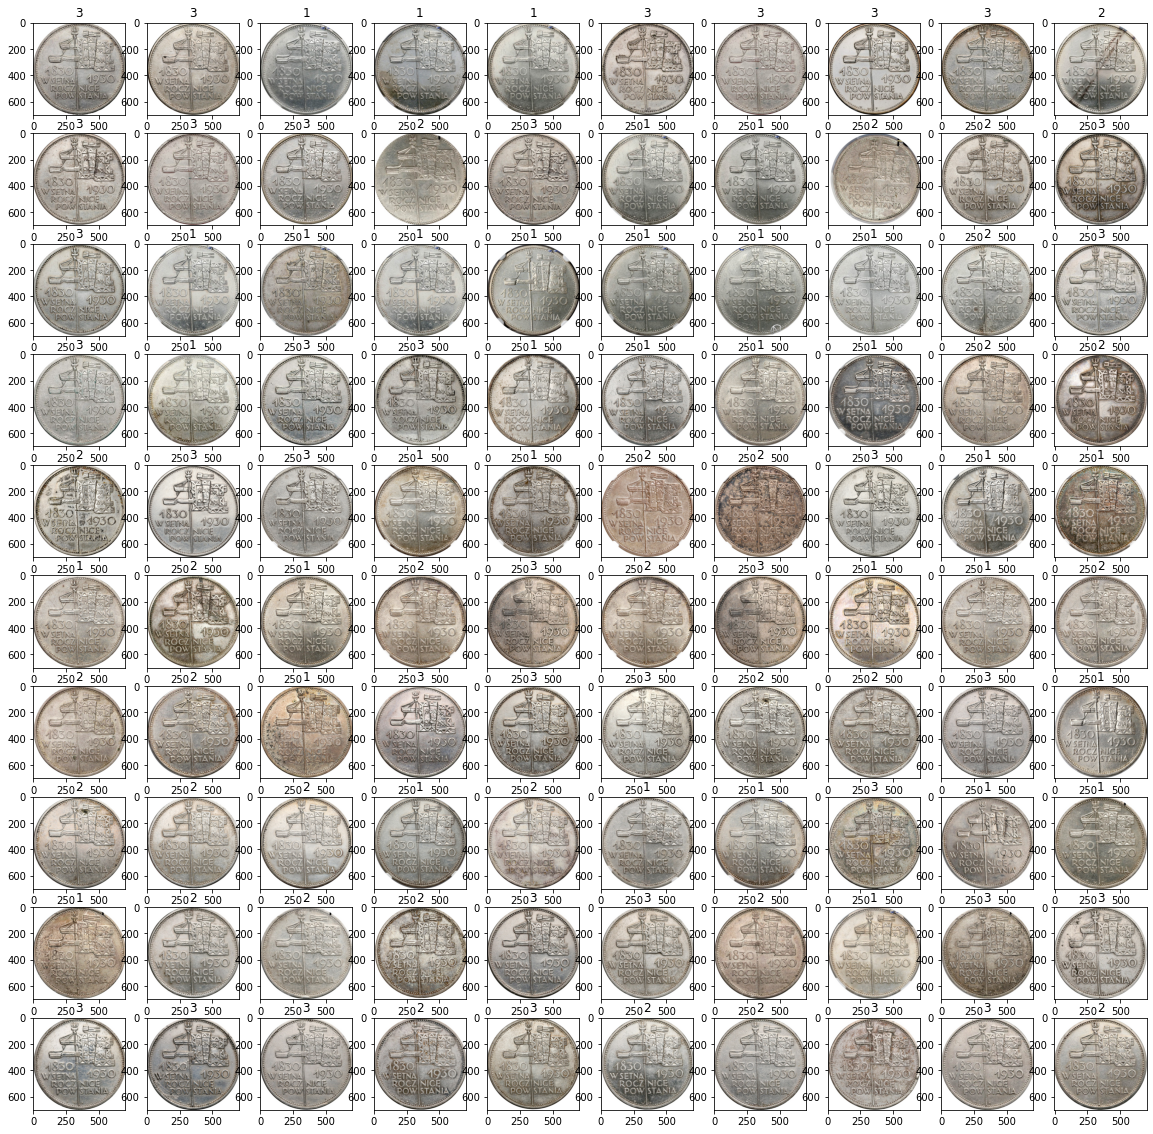

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(100):
    ax[i].imshow(cv2.cvtColor(dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i].set_title(dataset.y[i])
plt.show()

In [ ]:
wear_marks_dataset = convert_to_wear_marks_dataset(dataset, separate_sides=separate_sides, canny_l=None)

In [ ]:
fig, ax = plt.subplots(20, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(200):
    ax[i].imshow(cv2.cvtColor(wear_marks_dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i].set_title(wear_marks_dataset.y[i])
plt.show()

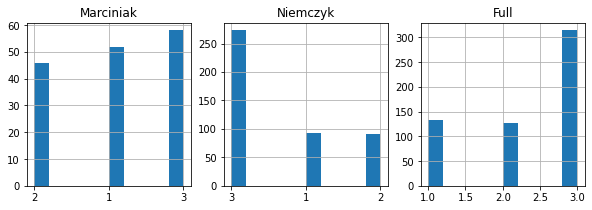

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

metadata_df = pd.read_csv(metadata_path(MARCINIAK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist(ax=ax[0])
ax[0].set_title("Marciniak")

metadata_df = pd.read_csv(metadata_path(NIEMCZYK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist(ax=ax[1])
ax[1].set_title("Niemczyk")

pd.Series(dataset.y).hist(ax=ax[2])
ax[2].set_title("Full")

plt.show()

## One side

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=True, uncertain=True))

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(100):
    ax[i].imshow(cv2.cvtColor(dataset.X[i], cv2.COLOR_BGR2RGB))
    ax[i].set_title(dataset.y[i])
plt.show()

# BoVW

In [5]:
AVERAGE_F1_SCORE = 'weighted'

def getDescriptorList(X, detector):
    separate_sides = len(X[0]) != 2
    unique_detector = detector is SiftGPUDetector
    if not separate_sides and not unique_detector:
      detector = [detector, detector]

    pbar = tqdm(total=len(X))
    descriptor_list = []
    for i, x in enumerate(X):
        if separate_sides:
          if unique_detector:
            detector = SiftGPUDetector(shape=x.shape)
          _, des = detector.detectAndCompute(x, None)
        else:
          if unique_detector:
            detector = [SiftGPUDetector(shape=x[0].shape), SiftGPUDetector(shape=x[1].shape)]
          _, des1 = detector[0].detectAndCompute(x[0], None)
          _, des2 = detector[1].detectAndCompute(x[1], None)
          des = np.concatenate([des1, des2])
        descriptor_list.append(des)          
        pbar.update(1)
    pbar.close()

    return descriptor_list

def trainModel(X_train, y_train, no_clusters, optimize_model,\
               detector, precomputed_descriptor_list=False,\
               separate_embedding=False, verbose=True):
    global train_descriptor_list

    kmeans_list = []
    scaler_list = []
    im_features_list = []

    subXs = [X_train[:,0], X_train[:,1]] if separate_embedding else [X_train]
    precomputed_descriptor_list = precomputed_descriptor_list and 'train_descriptor_list' in globals()

    for i, subX in enumerate(subXs):
        if not precomputed_descriptor_list:
            if i == 0:
                train_descriptor_list = []
            train_descriptor_list.append(getDescriptorList(subX, detector))

        descriptors = np.vstack(train_descriptor_list[i])
        if verbose: print("Descriptors computed.")

        kmeans_list.append(clusterDescriptors(descriptors, no_clusters))
        if verbose: print("Descriptors clustered.")

        im_features_list.append(extractFeatures(kmeans_list[i], train_descriptor_list[i], no_clusters))
        if verbose: print("Images features extracted.")

        scaler_list.append(StandardScaler().fit(im_features_list[i]))      
        im_features_list[i] = scaler_list[i].transform(im_features_list[i])
        if verbose: print("Train images normalized.")
    
    im_features = np.concatenate(im_features_list, axis=1) if separate_embedding else im_features_list[0]

    global train_im_features
    train_im_features = im_features

    # plotHistogram(im_features, no_clusters)
    # print("Features histogram plotted.")

    model = optimize_model(im_features, y_train)

    if verbose: print("Training completed.")

    return kmeans_list, scaler_list, model, im_features

def testModel(X_test, y_test, kmeans_list, scaler_list, model, im_features, no_clusters,
              detector,
              precomputed_descriptor_list=False,
              separate_embedding=False, verbose=True):
    global test_descriptor_list

    im_features_list = []

    subXs = [X_test[:,0], X_test[:,1]] if separate_embedding else [X_test]
    precomputed_descriptor_list = precomputed_descriptor_list and 'test_descriptor_list' in globals()

    for i, subX in enumerate(subXs):
        if not precomputed_descriptor_list:
            if i == 0:
                test_descriptor_list = []
            test_descriptor_list.append(getDescriptorList(subX, detector))

        im_features_list.append(extractFeatures(kmeans_list[i], test_descriptor_list[i], no_clusters))
        im_features_list[i] = scaler_list[i].transform(im_features_list[i])

    im_features = np.concatenate(im_features_list, axis=1) if separate_embedding else im_features_list[0]
        
    global test_im_features
    test_im_features = im_features

    predictions = model.predict(im_features)
    if verbose: print("Test images classified.")

    return predictions

def execute(
        X_train, X_test, y_train, y_test,\
        optimize_model, no_clusters,
        show_most_confused=False,
        verbose=True,
        **kwargs): 

    kmeans_list, scaler_list, model, im_features = trainModel(
        X_train, y_train, no_clusters, optimize_model,
        verbose=verbose,
        **kwargs)
    
    global train_predictions,test_predictions
    train_predictions = model.predict(im_features)
    test_predictions = testModel(X_test, y_test,
                                 kmeans_list,
                                 scaler_list,
                                 model, im_features, no_clusters,
                                 verbose=verbose,
                                 **kwargs)

    train_loss = f1_score(y_train, train_predictions, average=AVERAGE_F1_SCORE)
    test_loss = f1_score(y_test, test_predictions, average=AVERAGE_F1_SCORE)

    if verbose: plotConfusions(y_test, test_predictions)    
    if verbose: print("Train %.4f F1 score: (%s)" % (train_loss, AVERAGE_F1_SCORE))
    if verbose: print("Test %.4f F1 score (%s): "% (test_loss, AVERAGE_F1_SCORE))

    return train_loss, test_loss

    # if show_most_confused:
    #   idx = train_predictions != test_predictions
    #     onehot_encoder = OneHotEncoder(sparse=False)
    #     y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(-1, 1))
    #     mse_loss = pd.DataFrame("", index=np.arange())
    #     print(model.predict_proba(test_features))
    # print(onehot_encoded - y_test)   

def experiment(
    X_train, X_test, y_train, y_test, estimator, param_constructor, 
    n_list = [8, 16, 24, 32, 64, 96, 128],
    **kwargs):
    losses = []
    for n in n_list:
        optimizer = lambda x, y : optimize_model(x, y, estimator, param_constructor(n))
        train_loss, test_loss = execute(X_train, X_test, y_train, y_test, optimizer, n, verbose=len(n_list)==1, **kwargs)
        print("n=%d --> %.3f / %.3f" % (n, train_loss, test_loss))
        losses.append((train_loss, test_loss))
    return losses

def performExperiments(i, wear_marks_preprocessor, detection_parameters, h5_path=None):
  global train_descriptor_list, test_descriptor_list
  for j, separate_sides, uncertain, flags in detection_parameters:
    print(">>>>>>>{}.{}".format(i, j))
    
    if h5_path is None:
      h5_path=get_h5_name(separate_sides=separate_sides, uncertain=uncertain)
    dataset = load_dataset(h5_path=h5_path)
    wear_marks_dataset = wear_marks_preprocessor(dataset)
    del dataset
    
    # global wear_marks_dataset
    # wear_marks_dataset.X = wear_marks_dataset.X[:100]
    # wear_marks_dataset.y = wear_marks_dataset.y[:100]
    # wear_marks_dataset.name = wear_marks_dataset.name[:100]

    if 'train_descriptor_list' in globals():
      del train_descriptor_list
    if 'test_descriptor_list' in globals():
      del test_descriptor_list 

    global X_train, X_test, y_train, y_test, name_train, name_test
    [X_train, X_test, y_train, y_test, name_train, name_test] = train_test_split(
      wear_marks_dataset.X,
      wear_marks_dataset.y,
      wear_marks_dataset.name,
      stratify=wear_marks_dataset.y,
      test_size=0.3,
      random_state=42)
    del wear_marks_dataset

    n_list = [8, 16, 24, 32, 64, 96, 128]
    df = pd.DataFrame(index=n_list, columns=["SVM", "KNN", "RF", "LR"])

    for name, model, param_constructor in [
    ("SVM", SVC, lambda n: {
        'class_weight': ['balanced'],
        'C': [1, 0.8,  0.5, 1/5],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [5/n, 2/n, 1/n, 1/(2*n),  1/(5*n), 1/(15*n), 1/(30*n)]
      }),
    (
      "KNN", KNeighborsClassifier, lambda n: {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
      }),
    ("RF",RandomForestClassifier, lambda n: {
        'n_estimators' : [10, 15, 20, 30],
        'criterion' : ['gini', 'entropy'],
        'class_weight' : ["balanced","balanced_subsample"],
        'ccp_alpha': [0.02, 0.03],
      }),
    ("LR", LogisticRegression, lambda n:  {
        'C': [0.7, 0.3, 0.1, 0.05, 0.04, 0.02, 0.01],
        'class_weight' : ["balanced"],
      })
    ]:
      print("====" + name)
      df[name] = experiment(X_train, X_test, y_train, y_test, model, param_constructor, n_list = n_list, **flags)

    df = df.apply(lambda col: col.apply(lambda x: "%.3f / %.3f" % x), axis=1)
    df.to_csv("../results/{}_{}.csv".format(i, j))

## Experiments

### 1

In [ ]:
h5_path=get_h5_name(separate_sides=False, uncertain=True)
dataset = load_dataset(h5_path=h5_path)

In [6]:
basic_detection_params = [ 
  # (1, True, False,{
  #   'precomputed_descriptor_list': True,
  #   'separate_embedding': False, 
  #   'detector': SiftGPUDetector()
  # }),
  # (2, True, False, {
  #   'precomputed_descriptor_list': True,
  #   'separate_embedding': False, 
  #   'detector': BriefDetector()
  # }),
  # (3, False, False,{
  #   'precomputed_descriptor_list': True,
  #   'separate_embedding': False, 
  #   'detector': SiftGPUDetector()
  # }),
  # (4, False, False,{
  #   'precomputed_descriptor_list': True,
  #   'separate_embedding': True, 
  #   'detector': SiftGPUDetector()
  # }),
  (5, False, True, {
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()
  })
]

In [ ]:
performExperiments(
  1,
  lambda dataset: dataset,
  basic_detection_params
) 

### 2

In [ ]:
performExperiments(
  2,
  lambda dataset: convert_to_wear_marks_dataset(dataset),
  basic_detection_params
)

### 3

In [ ]:
performExperiments(
  3,
  lambda dataset: convert_to_wear_marks_dataset(dataset, {1: None, 2: None}, blur_size=3),
  [(1, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()
  })]
)

performExperiments(
  3,
  lambda dataset: convert_to_wear_marks_dataset(dataset, {1: None, 2: None}, blur_size=3),
  [(2, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': BriefDetector()
  })]
)

design_mask_dict = { \
  1: cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1_design_mask_edited.jpg", 0), \
  2: cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2_design_mask_edited.jpg", 0), \
}
performExperiments(
  3,
  lambda dataset: convert_to_wear_marks_dataset(dataset, design_mask_dict),
  [(3, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()
  })]
)
performExperiments(
  3,
  lambda dataset: convert_to_wear_marks_dataset(dataset, design_mask_dict),
  [(4, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': BriefDetector()
  })]
)

performExperiments(
  3,
  lambda dataset: convert_to_wear_marks_dataset(dataset, {1: None, 2: None}, ri_shape=(41,41)),
  [(5, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()
  })]
)

performExperiments(
  3,
  lambda dataset: convert_to_wear_marks_dataset(dataset, {1: None, 2: None}, ri_shape=(67,67)),
  [(6, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()
  })]
)

>>>>>>>3.1



====SVM


### 4

In [ ]:
performExperiments(
  4,
  lambda dataset: dataset,
  [(1, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector(shape=(600,600, 3))
  })],
   h5_path="two_sides_600.h5"
)

performExperiments(
  4,
  lambda dataset: dataset,
  [(2, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector(shape=(750,750, 3))
  })],
   h5_path="two_sides_750.h5"
)

>>>>>>>4.1
====SVM



{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.25, 'kernel': 'rbf'}



n=8 --> 0.725 / 0.535
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.125, 'kernel': 'rbf'}
n=16 --> 0.820 / 0.585
{'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.20833333333333334, 'kernel': 'linear'}
n=24 --> 0.681 / 0.533
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.03125, 'kernel': 'rbf'}
n=32 --> 0.838 / 0.610
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.015625, 'kernel': 'rbf'}
n=64 --> 0.871 / 0.623
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.010416666666666666, 'kernel': 'rbf'}
n=96 --> 0.874 / 0.635
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.0078125, 'kernel': 'rbf'}
n=128 --> 0.914 / 0.658
====KNN
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
n=8 --> 0.682 / 0.515
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
n=16 --> 1.000 / 0.527
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
n=24 --> 0.734 / 0.545
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=32 --> 1.000 / 0.601
{'metric': 'eucl


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.25, 'kernel': 'rbf'}



n=8 --> 0.729 / 0.550
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.125, 'kernel': 'rbf'}
n=16 --> 0.830 / 0.624
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
n=24 --> 0.801 / 0.593
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.03125, 'kernel': 'rbf'}
n=32 --> 0.827 / 0.620
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.03125, 'kernel': 'rbf'}
n=64 --> 0.911 / 0.688
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.010416666666666666, 'kernel': 'rbf'}
n=96 --> 0.880 / 0.631
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.0078125, 'kernel': 'rbf'}
n=128 --> 0.875 / 0.676
====KNN
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=8 --> 0.998 / 0.564
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
n=16 --> 1.000 / 0.596
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
n=24 --> 0.998 / 0.574
{'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
n=32 --> 0.805 / 0.578
{'metric': 'manhat

### 5


In [ ]:
# performExperiments(
#   5,
#   lambda dataset: convert_to_wear_marks_dataset(dataset, {1:None, 2:None}, blur_size=3, canny_l=70, canny_u=140),
#   [(1, False, False,{
#     'precomputed_descriptor_list': True,
#     'separate_embedding': False, 
#     'detector': SiftGPUDetector()
#   })]
# )

def toGray(dataset):
  wear_marks_dataset = Bunch(dataset)
  wear_marks_dataset.X = np.array([[ cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in x] for x in dataset.X])
  return wear_marks_dataset

performExperiments(
  5,
  toGray,
  [(1, False, False,{
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()
  })]
)

>>>>>>>5.1
====SVM



{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.625, 'kernel': 'rbf'}



n=8 --> 0.848 / 0.554
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.125, 'kernel': 'rbf'}
n=16 --> 0.847 / 0.613
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.08333333333333333, 'kernel': 'rbf'}
n=24 --> 0.851 / 0.661
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.15625, 'kernel': 'linear'}
n=32 --> 0.747 / 0.562
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.015625, 'kernel': 'rbf'}
n=64 --> 0.843 / 0.640
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.010416666666666666, 'kernel': 'rbf'}
n=96 --> 0.853 / 0.644
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.0078125, 'kernel': 'rbf'}
n=128 --> 0.904 / 0.672
====KNN
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
n=8 --> 1.000 / 0.569
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
n=16 --> 1.000 / 0.602
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
n=24 --> 0.703 / 0.601
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=32 --> 1.000 / 0.560
{'metric': 'euc

### 6

In [ ]:
separate_sides = False
uncertain = False

wear_marks_dataset = join_datasets([
  load_dataset(MARCINIAK_DATASET_PATH, separate_sides=separate_sides),
  load_dataset(NIEMCZYK_DATASET_PATH, separate_sides=separate_sides),
])

for params in basic_detection_params:
  if params[0] != 2:
    params[3]['detector'] = SiftGPUDetector

performExperiments(
  6,
  lambda dataset: dataset,
  basic_detection_params
)


>>>>>>>6.1
====SVM


## Models

In [ ]:
# dataset = load_dataset(h5_path=get_h5_name(separate_sides=False, uncertain=False))
wear_marks_dataset = convert_to_wear_marks_dataset(dataset)
flags = {
    'precomputed_descriptor_list': True,
    'separate_embedding': False, 
    'detector': SiftGPUDetector()# BriefDetector, SIFTDetector
    # 'detector': BriefDetector()
}

In [ ]:
del train_descriptor_list
del test_descriptor_list

NameError: ignored

In [ ]:
[X_train, X_test, y_train, y_test, name_train, name_test] = train_test_split(
    wear_marks_dataset.X,
    wear_marks_dataset.y,
    wear_marks_dataset.name,
    stratify=wear_marks_dataset.y,
    test_size=0.3,
    random_state=42)

### SVM

In [ ]:
%time

param_constructor = lambda n: {
    'class_weight': ['balanced'],
    'C': [
          # 10,
          # 7,
          # 2, 
          # 1.3,
          1,
          0.9,
          0.8,
          0.5, 
          1/5,
          # 1/10
          ],
    'kernel': [
               'linear',
               'poly', 
               'rbf',
               'sigmoid'
               ],
    'gamma': [
              # 30/n,
              # 15/n,
            #   5/n, 
              2/n, 
              1.5/n,
              1/n,
              1/(1.5*n),
              1/(2*n), 
              1/(5*n), 
            #   1/(15*n),
            #   1/(30*n)
             ]
    }

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'C': 0.9, 'class_weight': 'balanced', 'gamma': 0.005208333333333333, 'kernel': 'sigmoid'}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.57 0.15 0.28]
 [0.34 0.32 0.34]
 [0.2  0.26 0.54]]


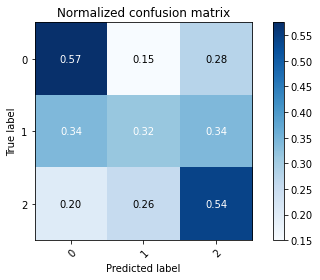

Train 0.5457 F1 score: (weighted)
Test 0.5087 F1 score (weighted): 
n=96 --> 0.546 / 0.509


[(0.5457459109119434, 0.5087334236237352)]

In [ ]:
n = 96
experiment(X_train, X_test, y_train, y_test, SVC, param_constructor, n_list=[n], **flags)

In [ ]:
svm_res = experiment(X_train, X_test, y_train, y_test, SVC, param_constructor, n_list = [8, 16, 24, 32, 64, 96, 128], **flags)


{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.25, 'kernel': 'rbf'}



n=8 --> 0.882 / 0.513
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.3125, 'kernel': 'linear'}
n=16 --> 0.646 / 0.391
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.041666666666666664, 'kernel': 'rbf'}
n=24 --> 0.882 / 0.574
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.03125, 'kernel': 'rbf'}
n=32 --> 0.932 / 0.562
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.0078125, 'kernel': 'rbf'}
n=64 --> 0.825 / 0.552
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.005208333333333333, 'kernel': 'rbf'}
n=96 --> 0.901 / 0.574
{'C': 0.8, 'class_weight': 'balanced', 'gamma': 0.00390625, 'kernel': 'rbf'}
n=128 --> 0.877 / 0.571


### KNN

In [ ]:
param_constructor = lambda n: {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [ ]:
knn_res = experiment(X_train, X_test, y_train, y_test, KNeighborsClassifier, param_constructor, **flags)

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
n=8 --> 0.599 / 0.468
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=16 --> 1.000 / 0.528
{'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
n=24 --> 1.000 / 0.535
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=32 --> 1.000 / 0.527
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
n=64 --> 0.662 / 0.522
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=96 --> 1.000 / 0.517
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
n=128 --> 1.000 / 0.498


Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.62 0.23 0.15]
 [0.34 0.26 0.39]
 [0.03 0.09 0.88]]


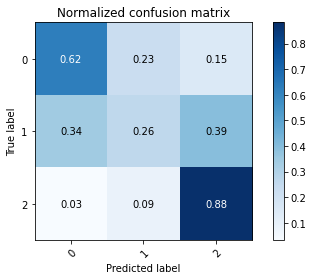

Train 1.0000 F1 score: (weighted)
Test 0.6697 F1 score (weighted): 
n=96 --> 1.000 / 0.670


[(1.0, 0.6697194565411619)]

In [ ]:
n_features = 96
experiment(X_train, X_test, y_train, y_test, KNeighborsClassifier, param_constructor, n_list=[n_features], **flags)

### RF

In [ ]:
param_constructor = lambda n: {
    'n_estimators' : [10, 15, 20, 30],
    'criterion' : ['gini', 'entropy'],
    'class_weight' : [
                      "balanced",
                      "balanced_subsample",
                      ],
    'ccp_alpha': [0.02, 0.03],
    # 'max_depth': [3, 4, 5]
    # 'min_samples_split': [20, 30, 50]
}

In [ ]:
rf_res = experiment(X_train, X_test, y_train, y_test, RandomForestClassifier, param_constructor, n_list = [8, 16, 24, 32, 64, 96, 128], **flags)

{'ccp_alpha': 0.02, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 15}
n=8 --> 0.861 / 0.427
{'ccp_alpha': 0.02, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 10}
n=16 --> 0.841 / 0.477
{'ccp_alpha': 0.03, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 30}
n=24 --> 0.867 / 0.487
{'ccp_alpha': 0.02, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 30}
n=32 --> 0.950 / 0.581
{'ccp_alpha': 0.02, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 30}
n=64 --> 0.970 / 0.523
{'ccp_alpha': 0.03, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 20}
n=96 --> 0.872 / 0.510
{'ccp_alpha': 0.02, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 10}
n=128 --> 0.943 / 0.454


Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'ccp_alpha': 0.02, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 30}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.6  0.14 0.26]
 [0.42 0.22 0.36]
 [0.18 0.15 0.67]]


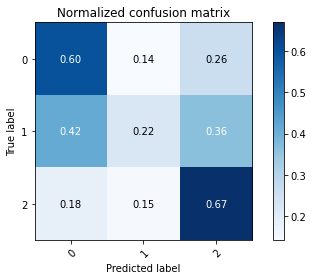

Train 0.7801 F1 score: (weighted)
Test 0.5517 F1 score (weighted): 
n=64 --> 0.780 / 0.552
0.780 / 0.552


In [ ]:
n_features = 64    
experiment(X_train, X_test, y_train, y_test, RandomForestClassifier, param_constructor, n_list=[n_features], **flags)

### LR

In [ ]:
param_constructor = lambda n:  {
    'C': [0.7, 0.3, 0.1, 0.05, 0.04, 0.02, 0.01],
    'class_weight' : ["balanced"],
}

In [ ]:
lr_res = experiment(X_train, X_test, y_train, y_test, LogisticRegression, param_constructor, n_list = [8, 16, 24, 32, 64, 96, 128], **flags)

{'C': 0.7, 'class_weight': 'balanced'}
n=8 --> 0.537 / 0.399
{'C': 0.02, 'class_weight': 'balanced'}
n=16 --> 0.551 / 0.424
{'C': 0.02, 'class_weight': 'balanced'}
n=24 --> 0.596 / 0.421
{'C': 0.01, 'class_weight': 'balanced'}
n=32 --> 0.595 / 0.494
{'C': 0.04, 'class_weight': 'balanced'}
n=64 --> 0.778 / 0.520
{'C': 0.01, 'class_weight': 'balanced'}
n=96 --> 0.780 / 0.518
{'C': 0.04, 'class_weight': 'balanced'}
n=128 --> 0.928 / 0.522


Descriptors computed.
Descriptors clustered.
Images features extracted.
Train images normalized.
{'C': 0.01, 'class_weight': 'balanced'}
Training completed.
Test images classified.
Normalized confusion matrix
[[0.64 0.27 0.09]
 [0.29 0.39 0.32]
 [0.16 0.23 0.61]]


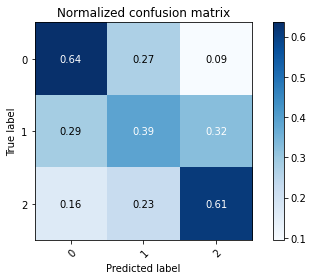

Train 0.6681 F1 score: (weighted)
Test 0.5824 F1 score (weighted): 
n=64 --> 0.668 / 0.582
0.668 / 0.582


In [ ]:
n_features = 64  
experiment(X_train, X_test, y_train, y_test, LogisticRegression, param_constructor, n_list=[n_features], **flags)

### Summary

In [ ]:
df = pd.DataFrame({"SVM": svm_res, "KNN": knn_res, "RF": rf_res, "LR": lr_res}, index = [8, 16, 24, 32, 64, 96, 128])
df = df.apply(lambda col: col.apply(lambda x: "%.3f / %.3f" % x), axis=1)
df.to_csv("results.csv")
df

SVM            KNN             RF             LR
8    0.882 / 0.513  0.599 / 0.468  0.861 / 0.427  0.537 / 0.399
16   0.646 / 0.391  1.000 / 0.528  0.841 / 0.477  0.551 / 0.424
24   0.882 / 0.574  1.000 / 0.535  0.867 / 0.487  0.596 / 0.421
32   0.932 / 0.562  1.000 / 0.527  0.950 / 0.581  0.595 / 0.494
64   0.825 / 0.552  0.662 / 0.522  0.970 / 0.523  0.778 / 0.520
96   0.901 / 0.574  1.000 / 0.517  0.872 / 0.510  0.780 / 0.518
128  0.877 / 0.571  1.000 / 0.498  0.943 / 0.454  0.928 / 0.522

## Error analysys

In [ ]:
from src.grade_processing_utils import unify_states

idx = test_predictions != y_test
metadata_dict = {
    i: unify_states(pd.read_csv(metadata_path(path), sep="|", index_col="id")[["title_state","description_state"]])
                 for i, path in (("N", NIEMCZYK_DATASET_PATH), ("M", MARCINIAK_DATASET_PATH))
} 
missclassified_df = pd.DataFrame({
    "name": name_test[idx],
    "pred": test_predictions[idx],
    "true": y_test[idx],
    "state": [metadata_dict[n[0]].loc[int(n.split("_")[0][1:]),"state"] for n in name_test[idx]]
    })

missclassified_experts = sum([s.startswith("GCN") or s.startswith("NGC") or s.startswith("PCGS") for s in missclassified_df["state"]])

print("%.2f of missclassified labels are not expert grades" % (1 - missclassified_experts/len(missclassified_df)))
print(missclassified_df)
missclassified_experts

# arr = df['state'].values
# ind = [s.startswith("GCN") or s.startswith("NGC") or s.startswith("PCGS") for s in arr]
# exp = [get_shaldon_value(s) for s in df.loc[ind, 'state']]
# exp = [get_circulate_category(s) for s in exp]

0.64 of missclassified labels are not expert grades
           name pred true      state
0    N387_1.jpg    2    3      2-/3+
1     N98_2.jpg    1    3         3+
2    N420_1.jpg    2    3       3-/4
3    N393_2.jpg    2    3         2-
4    N141_2.jpg    2    3         2-
..          ...  ...  ...        ...
147   M36_1.jpg    2    1  PCGS MS62
148  N198_2.jpg    2    3         3+
149  N127_2.jpg    2    1       1/1-
150  M114_2.jpg    1    2  PCGS AU58
151  N193_1.jpg    2    3          3

[152 rows x 4 columns]


54

## Visualize

### T-SNE

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=3, verbose=1, perplexity=3, learning_rate=200)
tsne_results = tsne.fit_transform(train_im_features)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.002s...
[t-SNE] Computed neighbors for 822 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.891880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.592934
[t-SNE] KL divergence after 1000 iterations: 1.771966


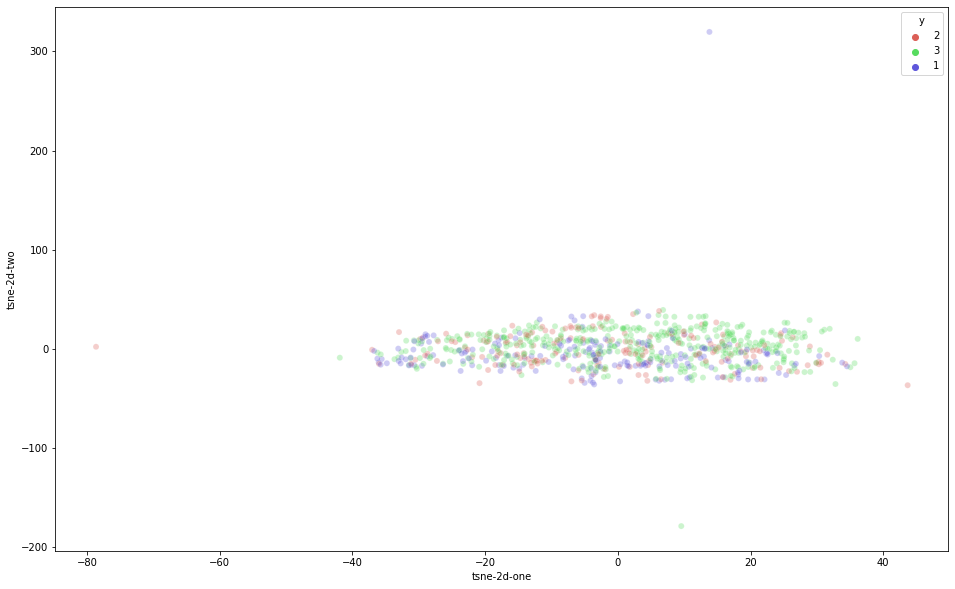

In [ ]:
tsne_df = pd.DataFrame({
    'y': y_train,
    'tsne-2d-one': tsne_results[:,0],
    'tsne-2d-two': tsne_results[:,1]
})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_im_features)

pca_df = pd.DataFrame({
    'y': y_train,
    'pca-one': pca_result[:,0],
    'pca-two': pca_result[:,1], 
    'pca-three': pca_result[:,2]
})

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.31 0.19 0.09]


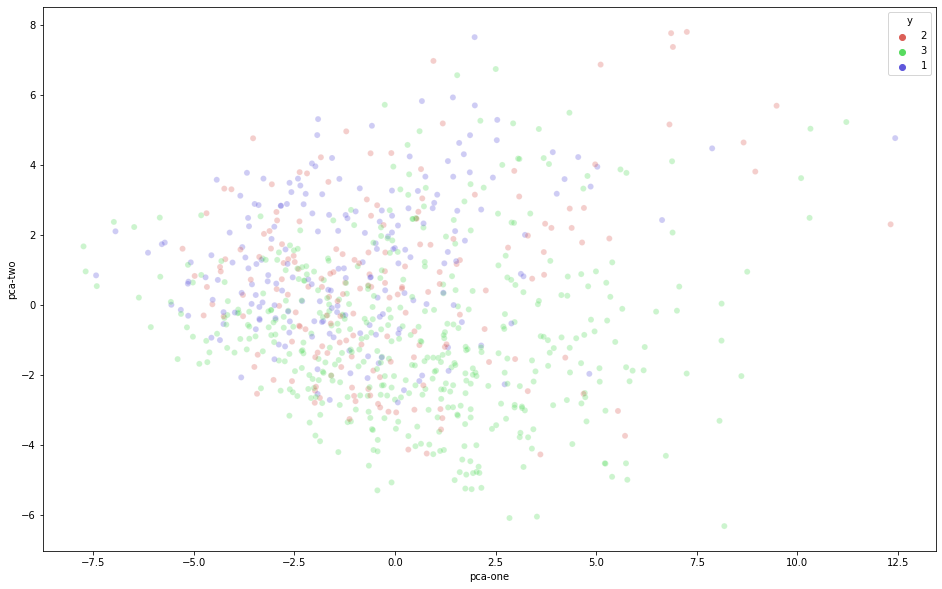

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=pca_df,
    legend="full",
    alpha=0.3
)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Happiness Score']
y = df['Economy (GDP per Capita)']
z = df['Health (Life Expectancy)']

ax.set_xlabel("Happiness")
ax.set_ylabel("Economy")
ax.set_zlabel("Health")

ax.scatter(x, y, z)

plt.show()

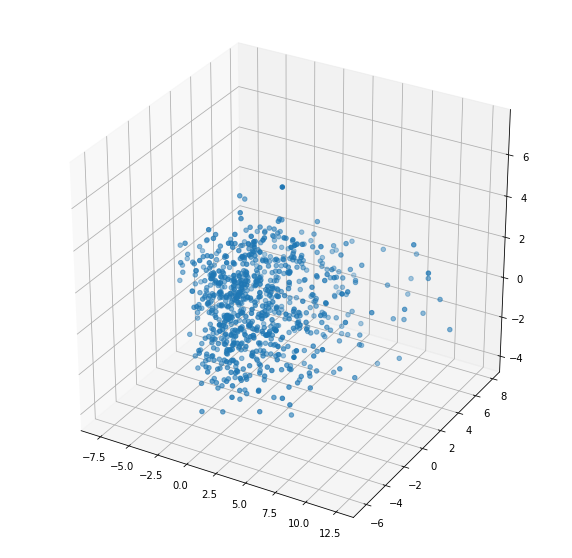

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df["pca-one"], pca_df["pca-two"], pca_df["pca-three"])
plt.show()

In [ ]:
dataset = load_dataset(h5_path=get_h5_name(separate_sides=False, uncertain=False))
wear_marks_dataset = convert_to_wear_marks_dataset(dataset, {1:None, 2:None})

[X_train, X_test, y_train, y_test, name_train, name_test] = train_test_split(
    wear_marks_dataset.X,
    wear_marks_dataset.y,
    wear_marks_dataset.name,
    stratify=wear_marks_dataset.y,
    test_size=0.3,
    random_state=42)

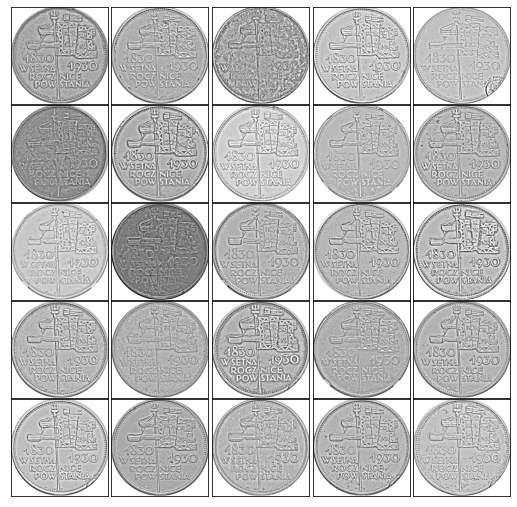

In [ ]:
coins = []
pbar = tqdm(total=len(X_train[:,0]))
for i, coin in enumerate(X_train[:,0]):
  coin = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
  coin = coin.flatten()
  coins.append(coin)
  pbar.update(1)
pbar.close()
 
fig, axes = plt.subplots(5,5, figsize=(9,9),
  subplot_kw={'xticks':[], 'yticks':[]},
  gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
  ax.imshow(coins[i].reshape(700,700), cmap='gray')

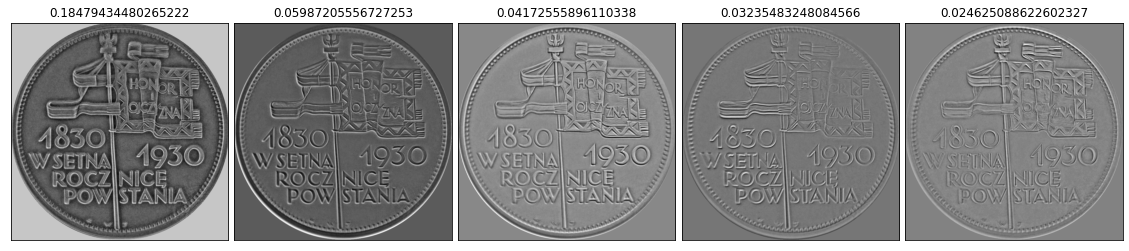

In [ ]:
#n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
# coin_pca = PCA(n_components=0.8)
# coin_pca.fit(coins)
fig, axes = plt.subplots(1,5,figsize=(20,4),
  subplot_kw={'xticks':[], 'yticks':[]},
  gridspec_kw=dict(hspace=0.01, wspace=0.01))

variances = coin_pca.explained_variance_ratio_
for i, ax in enumerate(axes.flat):
  ax.imshow(coin_pca.components_[i].reshape(700,700), cmap='gray')
  ax.set_title(variances[i])

## Separate classifier for each side

In [ ]:
ts_dataset = load_dataset(h5_path="two_sides_ds.h5")
ts_dataset_1 = Bunch(X=[x[0] for x in ts_dataset.X], y=ts_dataset.y)
ts_dataset_2 = Bunch(X=[x[1] for x in ts_dataset.X], y=ts_dataset.y)

In [ ]:
execute(ts_dataset_1, optimize_svm, 16, sift_gpu=True, precomputed_descriptor_list=False)

NameError: ignored

Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.
0.9 rbf 0.03125
Train weighted F1 score:  0.6785736212923476
Training completed.
Test images classified.
Confusion matrix, without normalization
[[32 10  3]
 [23 15 11]
 [16 20 42]]
Normalized confusion matrix
[[0.71 0.22 0.07]
 [0.47 0.31 0.22]
 [0.21 0.26 0.54]]


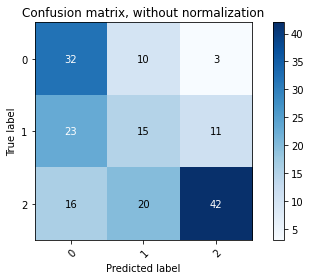

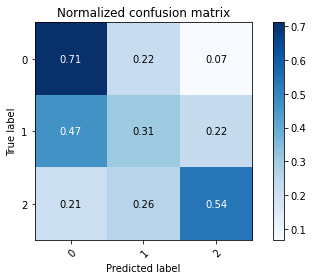

Confusion matrixes plotted.
Test weighted F1 score:  0.5195430608563761
Execution done.


In [ ]:
execute(ts_dataset_2, optimize_svm, 16, sift_gpu=True, precomputed_descriptor_list=False)

## SIFT comparison

In [ ]:
img.shape

(700, 700)

(700, 700, 3)


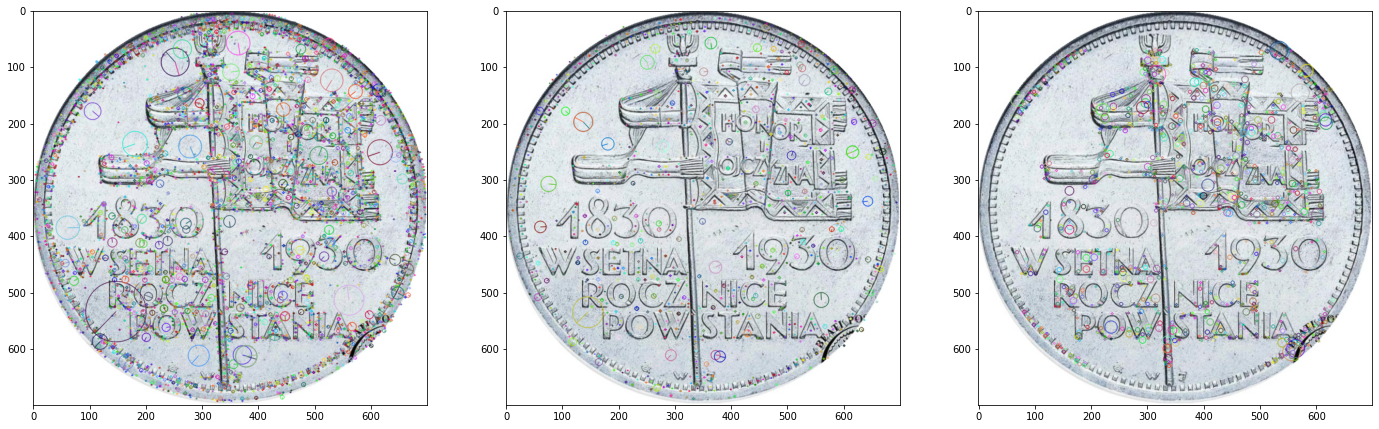

In [ ]:
# img = dataset.X[20]
# img = get_wear_marks(img, blur_size=3, canny_l=100, canny_u=200)

# img = X_train[-15]
img = cv2.resize(cv2.imread(aligned_coins_path(NIEMCZYK_DATASET_PATH) + "/379_2.jpg"), (700,700))
print(img.shape)

sift_gpu = SiftGPUDetector()
sift = SIFTDetector()
brief = BriefDetector()

kp, des = sift.detectAndCompute(img, None)
kp_gpu, des_gpu = sift_gpu.detectAndCompute(img, True)
kp_brief, des_brief = brief.detectAndCompute(img, None)

img_1 = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_2 = cv2.drawKeypoints(img, kp_gpu, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_3 = cv2.drawKeypoints(img, kp_brief, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1, 3, figsize=(24,8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)
plt.show()

# CNN

In [ ]:
from torchvision import transforms, models
import torchvision
from PIL import Image

In [ ]:
wear_marks_dataset = dataset

In [ ]:
class CustomTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        # self.targets = torch.LongTensor(targets)
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)
        return x, int(y-1)

    def __len__(self):
        return len(self.data)

In [ ]:
data_transforms = transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

[X_train, X_test, y_train, y_test] = \
  train_test_split(\
    wear_marks_dataset.X, wear_marks_dataset.y, test_size=0.3, random_state=42, stratify=wear_marks_dataset.y)

image_datasets = {
    "train": CustomTensorDataset(
            X_train,
            y_train,
            data_transforms
        ),
    "val": CustomTensorDataset(
            X_test,
            y_test,
            data_transforms
        )
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) \
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

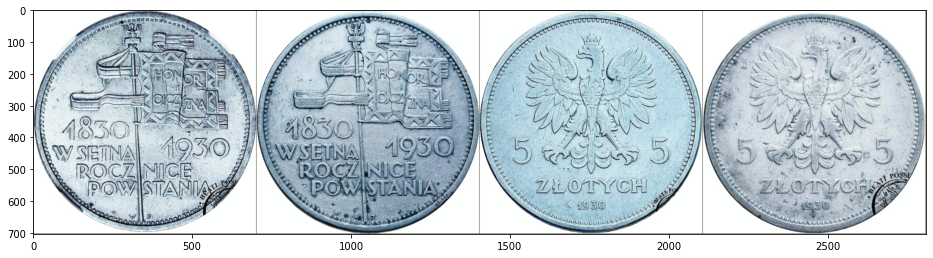

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,5))
imshow(out)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# np.sum(pd.isna(test_descriptor_list), axis=0)
name_test[-15]

NameError: ignored

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0160 Acc: 0.5620
val Loss: 0.6955 Acc: 0.6856

Epoch 1/9
----------
train Loss: 0.9068 Acc: 0.6509
val Loss: 0.6436 Acc: 0.7195

Epoch 2/9
----------
train Loss: 0.7321 Acc: 0.6934
val Loss: 0.7429 Acc: 0.7252

Epoch 3/9
----------
train Loss: 0.6623 Acc: 0.7360
val Loss: 0.7809 Acc: 0.7507

Epoch 4/9
----------
train Loss: 0.5276 Acc: 0.7895
val Loss: 1.0404 Acc: 0.7195

Epoch 5/9
----------
train Loss: 0.4995 Acc: 0.8054
val Loss: 0.8173 Acc: 0.6544

Epoch 6/9
----------
train Loss: 0.5281 Acc: 0.8041
val Loss: 1.2722 Acc: 0.7394

Epoch 7/9
----------
train Loss: 0.2892 Acc: 0.8954
val Loss: 0.6850 Acc: 0.7252

Epoch 8/9
----------
train Loss: 0.2424 Acc: 0.9173
val Loss: 0.6638 Acc: 0.7564

Epoch 9/9
----------
train Loss: 0.1787 Acc: 0.9489
val Loss: 0.7019 Acc: 0.7337

Training complete in 6m 51s
Best val Acc: 0.756374
